### Занятие 5. Типичные ошибки в обучении нейросетей и методы их отладки 

> ... “Fast and furious” approach to training neural networks does not work and only leads to suffering.

>Now, suffering is a perfectly natural part of getting a neural network to work well, but it can be mitigated by being thorough, defensive, paranoid, and obsessed with visualizations of basically every possible thing

http://karpathy.github.io/2019/04/25/recipe/

## Источник ошибок 1: данные и их подготовка
Обучение с учителем базируется на предпосылках:
1. Все сэмплы - независимые одинаково распределенные случайные величины ([iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables))
2. Сэмплы в тренировочном и тестовых датасетах взяты из одного распределения

Если эти предпосылки нарушаются - возникают проблемы.

#### Пример 1: не независимые (скоррелированные) сэмплы

Соревнование CVPR-2019 по ре-идентификации тигров: https://cvwc2019.github.io/challenge.html

**Задача**: имея пару изображений I\[1\] и I\[2\] ответить, один ли на них изображен тигр, или нет

**Данные**: кадры видео из зоопарков

**Результаты**: top-1 точность 0.98+!

Train

![alt text](images/train.jpg "Train Пример")

Test
![alt text](images/test.jpg "Test Пример")


#### **Вопрос-0**: нет ли в примерах данных этой задачи какой-то проблемы?

#### Пример 2: разные распределения train и test

Новоость из 2020: https://techcrunch.com/2020/04/27/google-medical-researchers-humbled-when-ai-screening-tool-falls-short-in-real-life-testing/

История про Google Health стартап, который для определения болезней глазного дна анализровал фото микроскопии. 

Решение имело высокую точность "в лабораторных условиях", но на практике показал плохие результаты.


**Основная причина**: при обучении (и тестировании) использовались качественные сканы высокого разрешения без дефектов, в реальности таких сканов оказалось не более 80%.

`Вывод:` 

Оценка качества не достоверна, если
- сэмплы датасета не независимые, а скоррелированные
- данные в test и train взяты из разных распределений

Скорее всего, измеренная оценка качества окажется завышенной.

#### **Вопрос-1:** стратификация (балансировка) данных по классу меняет распределение. Это ок или нет?

***
## Источник ошибок 2: модели и тренировка

### Пример ошибки 1: обучение модели

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random
random.seed(142)

import numpy as np
np.random.seed(142)

torch.manual_seed(142)


resnet_18 = torchvision.models.resnet18(pretrained=True)
resnet_18.fc = nn.Linear(in_features=512, out_features=2)

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def get_red_image():
    red_component = np.clip(np.random.rand(1), 0.2, 1.0)
    image = np.zeros((3, 128, 128))
    image[0,:,:] = red_component * 255
    return image

def get_blue_image():
    blue_component = np.clip(np.random.rand(1), 0.2, 1.0)
    image = np.zeros((3, 128, 128))
    image[2,:,:] = blue_component * 255
    return image

In [5]:
class RedAndBlueDataset(Dataset):
    def __init__(self, size):
        size = int(size/2)
        self.images = []
        self.labels = []
        for i in range(size):
            self.images.append(get_red_image())
            self.labels.append([0])
            self.images.append(get_blue_image())
            self.labels.append([1])
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample_images = torch.FloatTensor(self.images[idx])
        sample_labels = torch.LongTensor(self.labels[idx])
        return sample_images,  sample_labels
    
    def __len__(self):
        return len(self.labels)

In [6]:
train = RedAndBlueDataset(size=300)
test = RedAndBlueDataset(size=100)

tensor([1])

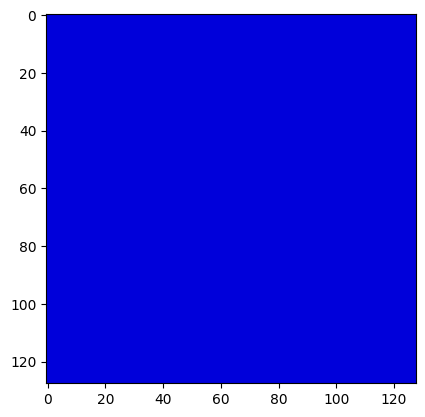

In [7]:
plt.imshow(
    transforms.ToPILImage()(test[5][0])
)
test[5][1]

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 50

trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)

testloader = DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_18.fc.parameters(), lr=0.01, momentum=0.8)

In [10]:

for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = resnet_18(inputs)
    loss = criterion(outputs, labels.view(-1))
    loss.backward()
    loss_value = loss.sum().detach().item()
    optimizer.step()
    print(loss_value)

  0%|          | 0/6 [00:00<?, ?it/s]

0.7933131456375122
0.6898597478866577
0.3911474347114563
0.15929386019706726
0.13359245657920837
0.032227132469415665


In [11]:
def calculate_accuracy(data_loader):
    total_labels = []
    total_predicts = []
    for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs, labels = data
        outputs = resnet_18(inputs)
        predicted_labels = np.argmax(outputs.cpu().detach().numpy(), axis=1).flatten().tolist()
        total_labels += labels.numpy().flatten().tolist()
        total_predicts += predicted_labels
    
    return accuracy_score(total_labels, total_predicts) #resnet_18.training

In [12]:
calculate_accuracy(trainloader)

  0%|          | 0/6 [00:00<?, ?it/s]

1.0

In [15]:
resnet_18.eval();

In [14]:
calculate_accuracy(testloader)

  0%|          | 0/2 [00:00<?, ?it/s]

0.86

#### **Вопрос-2**: в чем причина низкой accuracy на такой простой задаче?

***
### Пример ошибки 2: функция потерь

In [32]:
class DiceLoss(torch.nn.Module):
    """
    V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
    https://arxiv.org/pdf/1606.04797.pdf
    """
    def forward(self, predict, target):
        """
        Для каждого класса:
            DICE[C] = 2 * Sum(p * g) / ( Sum(p*p) + Sum(g*g) )
        Результат: Mean(DICE)
        """
        if predict.shape != target.shape:
            b, num_classes, h, w = predict.shape
            target = torch.nn.functional.one_hot(target.long(), num_classes=num_classes)
            target = target.squeeze(1).permute(0, 3, 1, 2)
            
        return 2 * (predict * target).sum() / (
            (predict * predict).sum() + (target * target).sum()
        )

crit = DiceLoss()

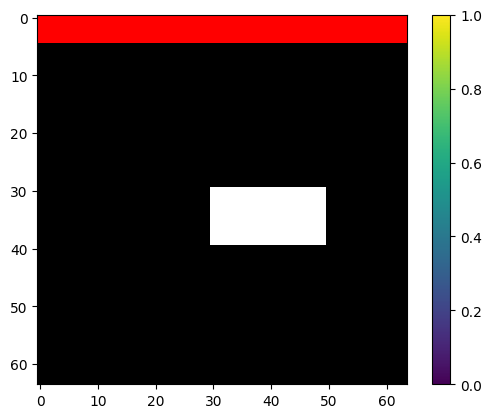

In [18]:
from segmentation_models_pytorch import Linknet

model = Linknet(classes=3, activation='softmax',     
    encoder_name='timm-mobilenetv3_small_minimal_100', 
)
model.encoder.requires_grad_(False)

fake_img = np.zeros((3, 64, 64))
fake_img[:, 30:40, 30:50] = 1
fake_img[0, :5] = 1


fake_mask = np.zeros((1, 64, 64))
fake_mask[:, 30:40, 30:50] = 1
fake_mask[:, :5] = 2

plt.imshow(np.transpose(fake_img, (1, 2, 0)))
plt.colorbar()

In [19]:
opt = optim.SGD(model.parameters(), lr=5e-3, momentum=0.8)

x = torch.tensor(fake_img)[None].float()
y = torch.tensor(fake_mask)[None].float()

for num in range(500):
    opt.zero_grad()
    yp = model(x)
    loss = crit(yp, y)
    loss.backward()
    loss_value = loss.sum().detach().item()
    opt.step()
    if num % 100 == 0:
        print(num, loss_value)

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


0 0.41001325845718384
100 0.10178621858358383
200 0.07314871996641159
300 0.06311854720115662
400 0.0564749576151371


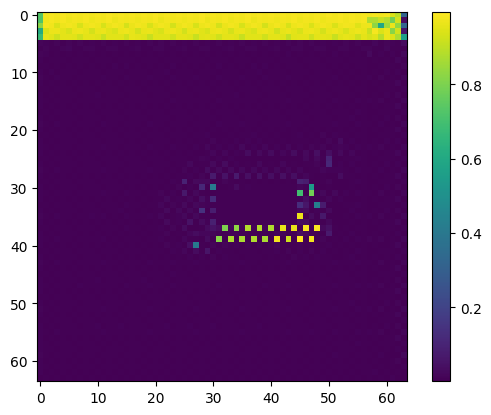

In [160]:
#plt.imshow(yp.detach().cpu()[0].permute(1, 2, 0))
plt.imshow(yp.detach().cpu()[0][0])
plt.colorbar()

#### **Вопрос-3**: что не так с DiceLoss? 

### Шахматный паттерн и ConvTranspose

https://distill.pub/2016/deconv-checkerboard/

Есть всегда при использовани ConvTranspose, использование обычных сверток после ConvTranspose позволяет его "сгладить"  и сделать менее заметным.

In [20]:
# Пример работы
inp_t = torch.arange(16, dtype=torch.float32).reshape(1, 1, 4, 4) + 1
kernel_t = torch.Tensor(
    [
        [1, -1],
        [100, -100]
    ],
).float().reshape(1, 1, 2, 2)
print("Input")
print(inp_t.numpy())
print("----------------")
print("Kernel")
print(kernel_t.numpy())
print("Result")
print("----------------")
print(torch.nn.functional.conv_transpose2d(inp_t, kernel_t, stride=2, padding=0, output_padding=0).long().numpy())

Input
[[[[ 1.  2.  3.  4.]
   [ 5.  6.  7.  8.]
   [ 9. 10. 11. 12.]
   [13. 14. 15. 16.]]]]
----------------
Kernel
[[[[   1.   -1.]
   [ 100. -100.]]]]
Result
----------------
[[[[    1    -1     2    -2     3    -3     4    -4]
   [  100  -100   200  -200   300  -300   400  -400]
   [    5    -5     6    -6     7    -7     8    -8]
   [  500  -500   600  -600   700  -700   800  -800]
   [    9    -9    10   -10    11   -11    12   -12]
   [  900  -900  1000 -1000  1100 -1100  1200 -1200]
   [   13   -13    14   -14    15   -15    16   -16]
   [ 1300 -1300  1400 -1400  1500 -1500  1600 -1600]]]]


In [21]:
print(torch.round(
    torch.nn.functional.conv_transpose2d(
    inp_t, 
    torch.tensor([
        [10, 100, 1000],
        [1, 2, 5],
        [-10, -100, -1000],
    ], dtype=torch.float32)[None, None], 
    stride=2, padding=1, output_padding=1
)).long().numpy())

[[[[     2      7      4     13      6     19      8     20]
   [   400   4040    400   4040    400   4040    400   4000]
   [    10     31     12     37     14     43     16     40]
   [   400   4040    400   4040    400   4040    400   4000]
   [    18     55     20     61     22     67     24     60]
   [   400   4040    400   4040    400   4040    400   4000]
   [    26     79     28     85     30     91     32     80]
   [ -1300 -13140  -1400 -14150  -1500 -15160  -1600 -16000]]]]


ConvTranspose можно инициализировать как приблизительно билинейный upsampling

In [22]:
upscale = torch.nn.ConvTranspose2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=3, 
    stride=2, 
    padding=1,
    output_padding=1,
    bias=False
)

tensor(-0.2354)


C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torch\nn\functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


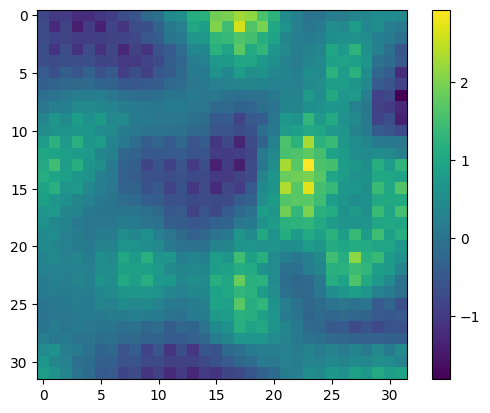

In [23]:
x1 = torch.randn(1, 1, 8, 8)
x2 = torch.nn.functional.upsample_bilinear(x1, size=(16, 16))
x4 = torch.nn.functional.upsample_bilinear(x2, size=(32, 32))

with torch.no_grad():
    y4 = upscale(x2)
plt.imshow(x4[0, 0] - y4[0, 0])
plt.colorbar()
print((y4[0, 0] - x4[0, 0] ).mean())

tensor(-0.0149)


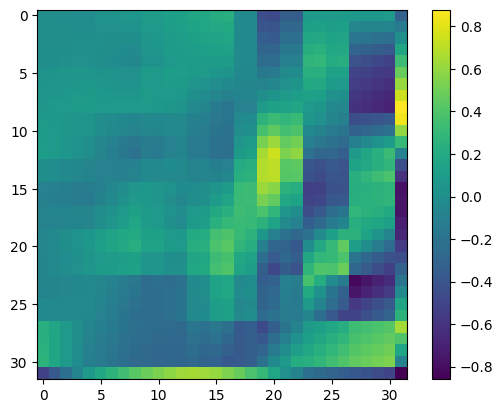

In [25]:
upscale.weight = nn.Parameter(torch.tensor([
    [0.25, 0.5, 0.25],
    [0.5, 1.0, 0.5],
    [0.25, 0.5, 0.25]
])[None, None])


with torch.no_grad():
    y4 = upscale(x2)
plt.imshow(y4[0, 0] - x4[0, 0])
plt.colorbar()
print((y4[0, 0] - x4[0, 0]).mean())

In [27]:
# часто используются kernel_size=(4, 4)
# параметры обучаемые, поэтому какого-то однозначного правила по размерам нет

model.decoder.blocks[0].block[1]

TransposeX2(
  (0): ConvTranspose2d(144, 144, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

***
### Пример ошибки 3: подготовка данных

In [28]:
class OneHotMaskDataset(Dataset):
    def __init__(self, size, image_shape=(32, 32), swap_xy=True):
        self.size = size
        self.image_shape = image_shape
        self.images = []
        self.masks = []
        self.swap_xy = swap_xy
        
        for _ in range(size):
            image, mask = self.generate_sample()
            self.images.append(image)
            self.masks.append(mask)
        
    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]
    
    def generate_sample(self):
        y_idx = np.random.randint(self.image_shape[1])
        x_idx = np.random.randint(self.image_shape[0])
        
        mask = np.zeros((1, ) + self.image_shape, dtype=np.float32)
        image = np.zeros((3,) + self.image_shape, dtype=np.float32)
        
        # (Псевдо-)ошибка - "перепутаны x и y"
        mask[:, y_idx, x_idx] = 1.
        if self.swap_xy:
            image[:, x_idx, y_idx] = 1.
        else:
            image[:, y_idx, x_idx] = 1.
            
        # добавим "синий" фон
        image[2, :, :] = 1.
        return torch.tensor(image), torch.tensor(mask)
    
    def __len__(self):
        return len(self.masks)
    
train_ds = OneHotMaskDataset(32000)
test_ds = OneHotMaskDataset(100)

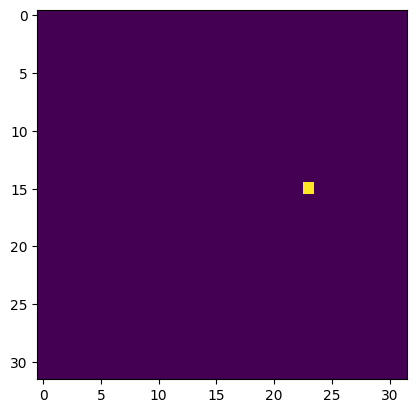

In [29]:
x, y = train_ds[42]
plt.imshow(transforms.ToPILImage()(y))

In [48]:
crit = DiceLoss()
device = torch.device('cpu:0')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(device)
model = Linknet(classes=1, activation='sigmoid',     
    encoder_name='timm-mobilenetv3_small_minimal_100', 
).to(device)

opt = optim.Adam(model.parameters(), lr=5e-3)
loss_values = []
for e in range(10):
    for num, (x, y) in enumerate(torch.utils.data.DataLoader(
        train_ds, batch_size=32, shuffle=True)):
        opt.zero_grad()
        yp = model(x.to(device))
        loss = crit(yp, y.to(device))
        loss.backward()
        loss_values.append(loss.sum().detach().item())
        opt.step()

        if num % 999 == 0:
            print(e, num, np.mean(loss_values))
            loss_values = []

cuda:0
0 0 -0.003930564969778061
0 999 -0.1461607699200429
1 0 -0.2796514630317688
1 999 -0.31597296728773994
2 0 -0.2960111200809479
2 999 -0.37069116465680235
3 0 -0.34172478318214417
3 999 -0.38994107683687035
4 0 -0.3047202229499817
4 999 -0.3736135376891395
5 0 -0.5075598955154419
5 999 -0.4035343232977617
6 0 -0.400287389755249
6 999 -0.3848566057550179
7 0 -0.43958616256713867
7 999 -0.391273222639933
8 0 -0.3548879325389862
8 999 -0.3934059776775949
9 0 -0.24693834781646729
9 999 -0.391645657228636


In [73]:
for e in range(30):
    for num, (x, y) in enumerate(torch.utils.data.DataLoader(
        train_ds, batch_size=32, shuffle=True)):
        opt.zero_grad()
        yp = model(x.to(device))
        loss = crit(yp, y.to(device))
        loss.backward()
        loss_values.append(loss.sum().detach().item())
        opt.step()

        if num % 999 == 0:
            print(e, num, np.mean(loss_values))
            loss_values = []

0 0 -0.30016663670539856
0 999 -0.3917287124751566
1 0 -0.4768858551979065
1 999 -0.40563934655847017
2 0 -0.3487330973148346
2 999 -0.40028932021634356
3 0 -0.27518555521965027
3 999 -0.3934476769849046
4 0 -0.3170424997806549
4 999 -0.40393447285299905
5 0 -0.3139904737472534
5 999 -0.3990265503003671
6 0 -0.31573790311813354
6 999 -0.3892779627123156
7 0 -0.4933586120605469
7 999 -0.37883860394134894
8 0 -0.32083502411842346
8 999 -0.38430517532296843
9 0 -0.39995649456977844
9 999 -0.37725394343709323
10 0 -0.3690958619117737
10 999 -0.41315046465909994
11 0 -0.3119426965713501
11 999 -0.44565700264545055
12 0 -0.5245887041091919
12 999 -0.4657513228085664
13 0 -0.45403680205345154
13 999 -0.47706158893244405
14 0 -0.4929077923297882
14 999 -0.49095071655314965
15 0 -0.47944873571395874
15 999 -0.4843755897071149
16 0 -0.4674658179283142
16 999 -0.49215933711858123
17 0 -0.38767534494400024
17 999 -0.4948418617203787
18 0 -0.43273815512657166
18 999 -0.5016154998594576
19 0 -0.4387

In [74]:
model_swap = model.cpu()

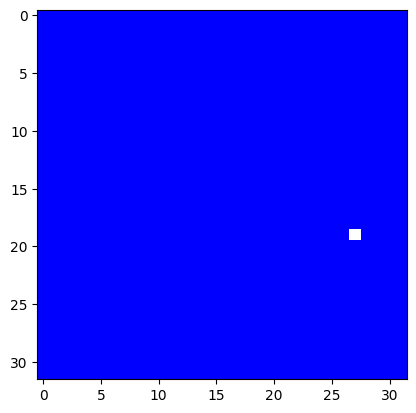

In [101]:
(x, y) = next(iter(torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)))
with torch.no_grad():
    yp = model_swap(x)
    
plt.imshow(transforms.ToPILImage()(x[8]))


Несмотря на ошибочно повернутый на 90 градусов таргет - сеть в ряде случаев предсказывает маску правильно или похоже.

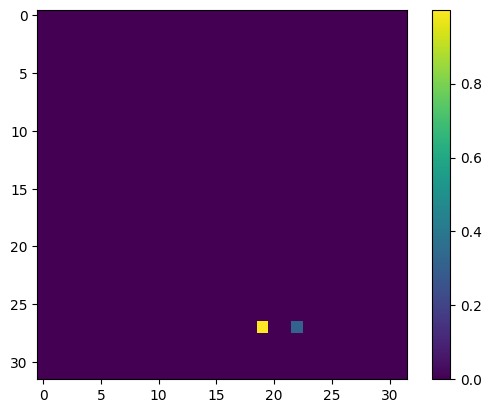

In [106]:
plt.imshow(yp[8, 0])# - y[8, 0])
plt.colorbar()

In [76]:
# Тренировка без "ошибки" индексов

train_ds_fix = OneHotMaskDataset(32000, swap_xy=False)
test_ds_fix = OneHotMaskDataset(100, swap_xy=False)

crit = DiceLoss()

model = Linknet(classes=1, activation='sigmoid',     
    encoder_name='timm-mobilenetv3_small_minimal_100', 
)
#model.encoder.requires_grad_(False)

opt = optim.Adam(model.parameters(), lr=5e-3)
loss_values = []
for e in range(1):
    for num, (x, y) in enumerate(torch.utils.data.DataLoader(train_ds_fix, batch_size=16, shuffle=True)):
        opt.zero_grad()
        yp = model(x)
        loss = crit(yp, y)
        loss.backward()
        loss_values.append(loss.sum().detach().item())
        opt.step()

        if num % 250 == 0:
            print(e, num, np.mean(loss_values))
            loss_values = []

0 0 -0.005875847768038511
0 250 -0.8268946093413979
0 500 -0.9904865589141846
0 750 -0.9959395039081573
0 1000 -0.9999374618530273
0 1250 -0.990722720861435
0 1500 -0.996823409318924
0 1750 -0.9998445980548859


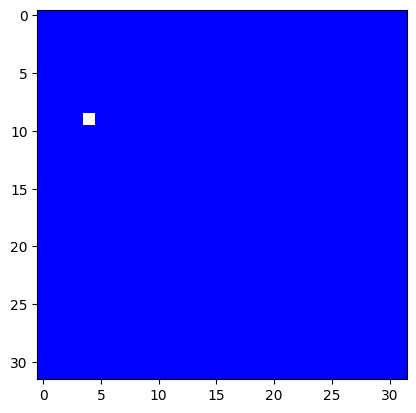

In [77]:
(x, y) = next(iter(torch.utils.data.DataLoader(test_ds_fix, batch_size=16, shuffle=False)))
with torch.no_grad():
    yp = model(x)
    
plt.imshow(transforms.ToPILImage()(x[12]))


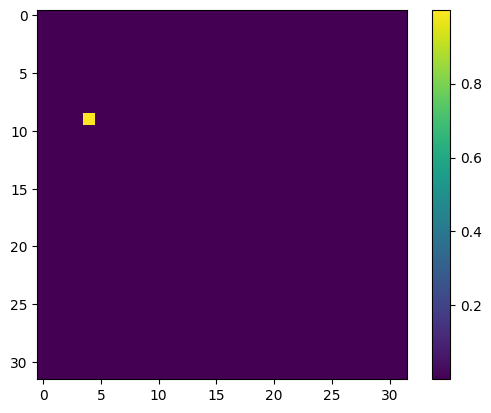

In [78]:
plt.imshow(yp[12, 0])
plt.colorbar()

***
### Пример ошибки 4: архитектура модели

In [79]:
from torchvision.models import resnet18

In [80]:
class Mean(nn.Module):
    def forward(self, x):
        return x.mean(axis=[-1, -2])

class CifarClassifier(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        md = resnet18(pretrained=True)
        self.backbone = nn.Sequential(
            md.conv1,
            md.bn1,
            md.relu,
            md.maxpool,
            md.layer1,
            md.layer2,
            md.layer3,
            md.layer4
        )
        self.head = nn.Sequential(
            Mean(),
            nn.Linear(in_features=512, out_features=n_classes),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model = CifarClassifier()

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
from pathlib import Path

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_path = Path().absolute() / 'data'

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [82]:
n_print_loss = 100
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
criterion = torch.nn.NLLLoss()

for epoch in range(5):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=50000/batch_size):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % n_print_loss == (n_print_loss - 1): 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/500.0 [00:00<?, ?it/s]

[1,   100] loss: -0.041
[1,   200] loss: -0.048
[1,   300] loss: -0.049
[1,   400] loss: -0.049
[1,   500] loss: -0.049


  0%|          | 0/500.0 [00:00<?, ?it/s]

[2,   100] loss: -0.049
[2,   200] loss: -0.050
[2,   300] loss: -0.050
[2,   400] loss: -0.050
[2,   500] loss: -0.050


  0%|          | 0/500.0 [00:00<?, ?it/s]

[3,   100] loss: -0.050
[3,   200] loss: -0.050
[3,   300] loss: -0.050
[3,   400] loss: -0.050
[3,   500] loss: -0.050


  0%|          | 0/500.0 [00:00<?, ?it/s]

[4,   100] loss: -0.050
[4,   200] loss: -0.050
[4,   300] loss: -0.050
[4,   400] loss: -0.050
[4,   500] loss: -0.050


  0%|          | 0/500.0 [00:00<?, ?it/s]

[5,   100] loss: -0.050
[5,   200] loss: -0.050
[5,   300] loss: -0.050
[5,   400] loss: -0.050
[5,   500] loss: -0.050
Finished Training


In [83]:
from sklearn.metrics import confusion_matrix

correct_labels = []
predicted_labels = []

model = model.to('cpu')

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        predicted_labels = [*predicted_labels, *predictions]
        correct_labels = [*correct_labels, *labels]
        
matrix = confusion_matrix(correct_labels, predicted_labels)

def plot_confusion_matrix(mtx, cls_names):
    fig, ax = plt.subplots()
    im = ax.imshow(mtx, cmap="seismic")
    
    try:
        ax.set_xticks(np.arange(len(cls_names)))
        ax.set_xticklabels(cls_names)
        ax.set_yticks(np.arange(len(cls_names)))
        ax.set_yticklabels(cls_names)
    except:
        # matplotlib api changed
        pass
        
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cls_names)):
        for j in range(len(cls_names)):
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center")
    
    acc = (np.eye(len(mtx)) * mtx).sum() / (mtx.sum() + 1e-4)
    ax.set_title(f"Confusion matrix CIFAR10. Accuracy: {acc * 100: .2f} %")
    fig.tight_layout()
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

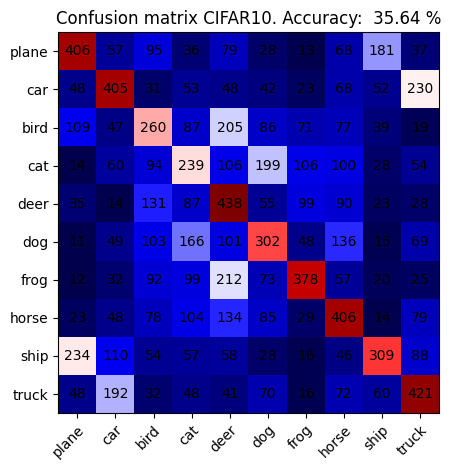

In [84]:
plot_confusion_matrix(matrix, cls_names=classes)

#### **Вопрос-4**: что не так с моделью?

***
### Отладка сетей: saliency maps (карты значимости)
Дано: 
- сеть-классификатор `M`
- изображение `I\[H,W,3\]`
- результат классификации `y = M(I)`

Хотим узнать, куда сеть смотрела при классификации изображения, т.е. вклад пикслей входа в значение выхода.

Можно считать по разному, самый простой - `S[H, W] = dy/dI[H, W]`, (т.е. градиент выхода по входу)


In [85]:
model = torchvision.models.resnet50(pretrained=True)


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\bzimka\Anaconda3\envs\torchedu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### **Задача**: допишите функцию saliency

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    model_input = transform(img)
    model_input.unsqueeze_(0)
    model_input.requires_grad = True
    
    preds = model(model_input)
    score, indices = torch.max(preds, 1)
  
    score.backward()
    
    # Строчку ниже заменить на подсчет saliency
    slc = np.zeros((model_input[0]).shape[1:])
        
    with torch.no_grad():
        input_img = inv_normalize(model_input[0])
        
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc, cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


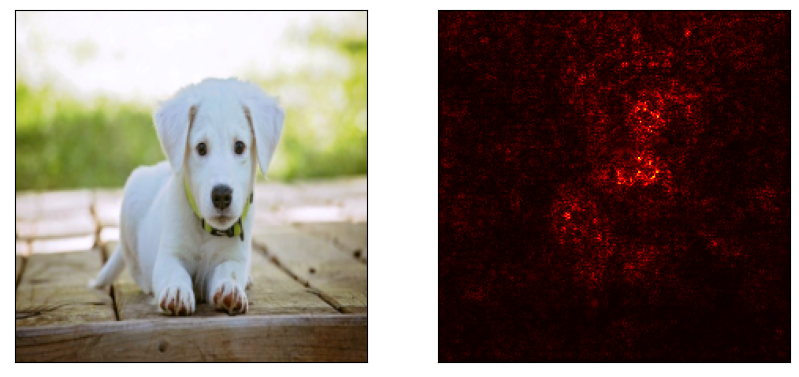

In [345]:
img = Image.open('images/puppy.jpg').convert('RGB')
saliency(img, model.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


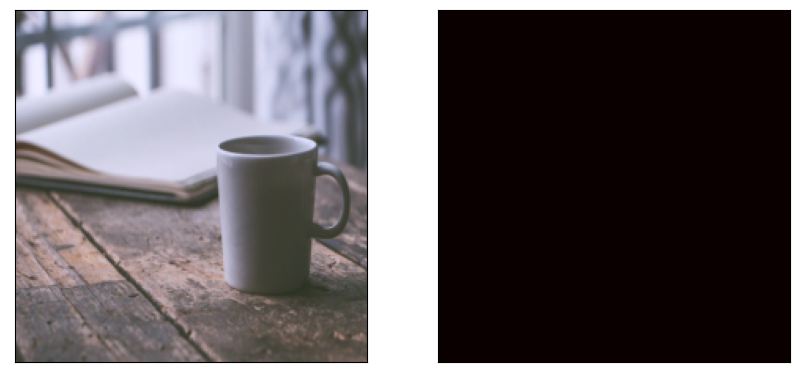

In [88]:
img = Image.open('images/coffee_mug.jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


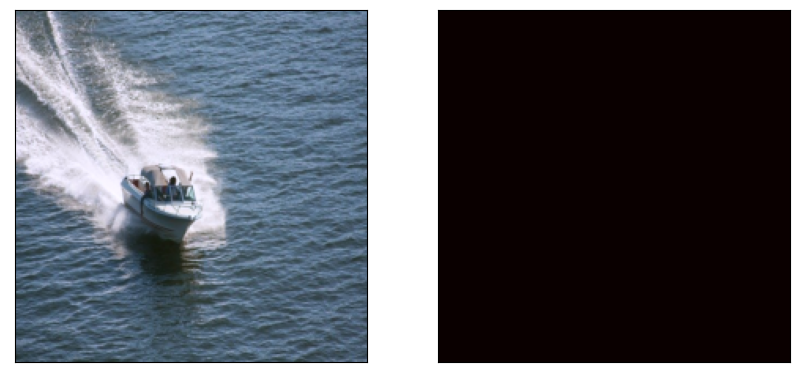

In [87]:
img = Image.open('images/speed_boat.jpg').convert('RGB')
saliency(img, model)